In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os, json

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
from pprint import pprint

import functions as fn

# Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
FPATHS = dict(
    data={
        "processed": "Data-NLP/processed-reviews-hoover.joblib",
        "ml": {
            "train": "Data-NLP/training-data.joblib",  
            "test": "Data-NLP/testing-data.joblib",
            "label_encoder":"Data-NLP/label-encoder.joblib",
            'target_lookup':"Data-NLP/target-lookup-dict.joblib",
            
        },
        "tf": {
            "train_tf": "Data-NLP/training_tf",  
            "test_tf": "Data-NLP/testing_tf", 
         },           
    },
    models={
        "ml": "models/ml-pipe.joblib", 
        "nlp": "models/nb-pipe.joblib",
    },
)
pprint(FPATHS)

{'data': {'ml': {'label_encoder': 'Data-NLP/label-encoder.joblib',
                 'target_lookup': 'Data-NLP/target-lookup-dict.joblib',
                 'test': 'Data-NLP/testing-data.joblib',
                 'train': 'Data-NLP/training-data.joblib'},
          'processed': 'Data-NLP/processed-reviews-hoover.joblib',
          'tf': {'test_tf': 'Data-NLP/testing_tf',
                 'train_tf': 'Data-NLP/training_tf'}},
 'models': {'ml': 'models/ml-pipe.joblib', 'nlp': 'models/nb-pipe.joblib'}}


In [4]:
os.makedirs('config/', exist_ok=True)
FPATHS_FILE = 'config/filepaths.json'
with open(FPATHS_FILE, 'w') as f:
    json.dump(FPATHS, f)

#### Prepping Data

In [5]:
# Using function to create the directories
fn.create_directories_from_paths(FPATHS)

In [6]:
# loading processed data
fpath = FPATHS['data']['processed']
df = joblib.load(fpath)
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,rating,rated,tweet_token,spacy_lemmas,joined_token,joined_lemmas
0,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"a guilty pleasure for me personally, as i love...",9.0,HIGH,"[a, guilty, pleasure, for, me, personally, ,, ...","[guilty, pleasure, personally, love, great, es...","a guilty pleasure for me personally , as i lov...",guilty pleasure personally love great escape w...
1,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"the first underwhelmed me, but this one straig...",3.0,LOW,"[the, first, underwhelmed, me, ,, but, this, o...","[underwhelme, straight, bore, course, see, hun...","the first underwhelmed me , but this one strai...",underwhelme straight bore course see hunt clim...
2,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,after quite entertainign mission impossible i ...,2.0,LOW,"[after, quite, entertainign, mission, impossib...","[entertainign, mission, impossible, second, in...",after quite entertainign mission impossible i ...,entertainign mission impossible second install...


In [7]:
# assign X and y
X = df['review']
y = df['rated']

In [8]:
# train test split
X_train, X_test, y_train_str, y_test_str = train_test_split(X,y,test_size=0.25,
                                                    random_state=42)

In [9]:
# Getting unique classes to convert 
class_names = y_train_str.unique()
class_names

array(['LOW', 'HIGH'], dtype=object)

In [10]:
# Fit the label encoder on unique class names
encoder = LabelEncoder()
encoder.fit(class_names)

LabelEncoder()

In [13]:
# Extract the class names from the encoder
classes = encoder.classes_

In [14]:
encoder.transform(classes)

array([0, 1])

In [15]:
# Transform the y_train_str and y_test_str with encoder
y_train = encoder.transform(y_train_str)
y_test = encoder.transform(y_test_str)
y_train[:10]

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0])

In [16]:
# Get the encoded values for each both classes
class_codes = encoder.transform(classes)
class_codes

array([0, 1])

In [17]:
# target lookup
target_lookup = dict(zip(class_codes,classes))
target_lookup

{0: 'HIGH', 1: 'LOW'}

In [22]:
# saving
fpath_train = FPATHS['data']['ml']['train']
joblib.dump([X_train, y_train], fpath_train)
fpath_test = FPATHS['data']['ml']['test']
joblib.dump([X_test, y_test], fpath_test)
fpath_encoder = FPATHS['data']['ml']['label_encoder']
joblib.dump(encoder, fpath_encoder)
fpath_lookup = FPATHS['data']['ml']['target_lookup']
joblib.dump(target_lookup, fpath_lookup)

['Data-NLP/target-lookup-dict.joblib']

#### ML

In [23]:
## Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                     ('clf',RandomForestClassifier(random_state=42))])
clf_pipe

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

In [24]:
# fit model pipeline
clf_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       888
           1       1.00      1.00      1.00       926

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



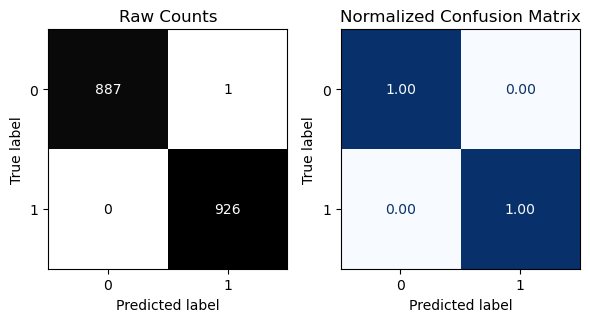


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       307
           1       0.84      0.82      0.83       298

    accuracy                           0.84       605
   macro avg       0.84      0.84      0.84       605
weighted avg       0.84      0.84      0.84       605



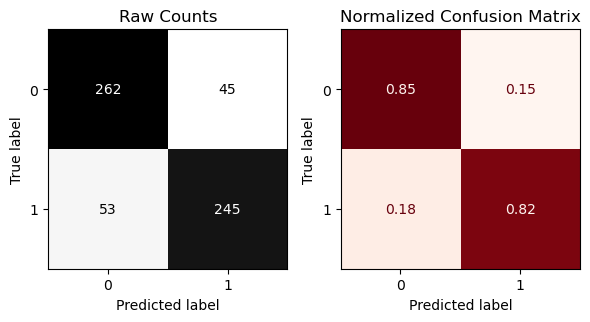

In [25]:
# evaluate model
fn.evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test)

In [26]:
# Save the model
fpath_ml_pipe = FPATHS['models']['ml']
joblib.dump(clf_pipe, fpath_ml_pipe)

['models/ml-pipe.joblib']

#### NLP

In [27]:
# Fit and Transform the strings into integers
y = pd.Series(encoder.fit_transform(y))
y.value_counts()

1    1224
0    1195
dtype: int64

In [28]:
# Convert to Dataset object
ds = tf.data.Dataset.from_tensor_slices((X, y))
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [29]:
# Convert to Dataset object
ds = tf.data.Dataset.from_tensor_slices((X, y))
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [30]:
# Add a column to the dataframe that has the length of each paragraph
df['sequence_length'] = df['review'].map( lambda x: len(x.split(" ")))

In [31]:
df['sequence_length'].describe()

count    2419.000000
mean      225.767673
std       270.815728
min         1.000000
25%        62.000000
50%       143.000000
75%       286.500000
max      4017.000000
Name: sequence_length, dtype: float64

In [32]:
# maximum length = sequence length max
SEQUENCE_LENGTH = 4017

In [33]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

In [34]:
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

In [35]:
# Set the batch size
BATCH_SIZE =32

In [36]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [37]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

In [38]:
# Create keras text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [39]:
# Fit/Adapt the text vectorization layer on the training texts.
sequence_vectorizer.adapt(ds_texts)

In [40]:
# Save the vocabulary size from the layer to use in your models' Embedding layer.
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()

In [41]:
# unique classes
classes = y.unique()
classes

array([0, 1])

In [42]:
# Function - using the model that performed best in core projects
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(64, return_sequences = True)))
    gru_model_bi_pool.add(layers.Dropout(.2))
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(64, return_sequences = True)))
    # Add a pooling layer *new
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

In [ ]:
EMBED_DIM = 100
#Build the model
model = build_gru_model_bi_pool(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=fn.get_callbacks(),
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 4017)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 4017, 100)         2474900   
                                                                 
 bidirectional (Bidirectiona  (None, 4017, 128)        63744     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 4017, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4017, 128)        74496     
 nal)                                                            
                                                        

In [ ]:
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

In [ ]:
# Save the model
fpath_nlp_pipe = FPATHS['models']['nlp']
tf.keras.models.save_model(model, fpath_nlp_pipe, save_format='tf')

# Stuff